<a href="https://colab.research.google.com/github/gmazzitelli/GSN2/blob/master/R_th.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import seaborn as sns
sns.set()
#plt.style.use('fast')
#plt.rc('font', size = 14, family ='Sans-Serif')
def panda_from_gspreadsheet(key, sheet_name='Sheet1'):
  # google spredsheet TO panda dataframe 
  # ricordarsi di abilitare lo sharing pubblico dei dati
  url = 'https://docs.google.com/spreadsheets/d/{key}/gviz/tq?tqx=out:csv&sheet={sheet_name}&headers=1'.format(
      key=key, sheet_name=sheet_name.replace(' ', '%20'))
  return pd.read_csv(url)

# DATI COVID Nazionali https://github.com/pcm-dpc/COVID-19
# download updated data
# repository italy https://github.com/pcm-dpc/COVID-19/tree/master/dati-andamento-nazionale
url_csv_file = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
df = pd.read_csv(url_csv_file)
# DATI COVID REGIONI
# istat http://dati.istat.it/Index.aspx?QueryId=26428#
url_csv_file = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv"
dr = pd.read_csv(url_csv_file)
Lombardia = dr.loc[(dr['denominazione_regione'] == 'Lombardia')].sort_values(by="data").copy()
Lazio = dr.loc[(dr['denominazione_regione'] == 'Lazio')].sort_values(by="data").copy()
Italia = df.copy() 
# DATI Popolazione Regioni
dpr = panda_from_gspreadsheet('1qL5B_J6eV6bD9zicR0YsCIaUMU0BhTdSTrqC1UcDBI8', sheet_name='Sheet1')
# DATI COVID Provincie
url_csv_file = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province.csv"
dp = pd.read_csv(url_csv_file)
pr =  panda_from_gspreadsheet('1Hf3s74TRWnhLkKYOM3XOdFwqyZEuxkl0Rxx8xjLmeZs', sheet_name='Sheet1')
 
print('aggiornamento al '+str(np.array(df['data'])[-1])[0:10])
def Exp(x, p0, p1): # negative exponential
    import numpy as np
    return p0*np.exp(x/p1)
 
def Infected(t, I0, mu, R0): # negative exponential
    import numpy as np
# https://medium.com/data-for-science/epidemic-modeling-101-or-why-your-covid19-exponential-fits-are-wrong-97aa50c55f8
    return I0*np.exp(mu*(R0-1)*t)
 
# def Logistic(x, L, k, x0):
#     import numpy as np
#     return L / (1. + np.exp(-k * (x - x0)))
 
def Logistic(x, a, b, c):
    import numpy as np
# https://it.wikipedia.org/wiki/Equazione_logistica
    return a / (1. + b * np.exp(-c * x))
 
def Logistic4(x, a, b, c, d):
    import numpy as np
# https://it.wikipedia.org/wiki/Equazione_logistica
    return a / (1. + b * np.exp(-c * x)) + d
 
def dLogistic(x, a, b, c):
    import numpy as np
    return a*b*c*np.exp(c*x)/(b+np.exp(c*x))**2
 
def Gompertz(x, a, b, c):
    import numpy as np
# https://en.wikipedia.org/wiki/Gompertz_function
    return a * np.exp(-b * np.exp(-c * x))
 
def dGompertz(x, a, b, c):
  import numpy as np
# https://en.wikipedia.org/wiki/Gompertz_function
  return a*b*c * np.exp(-b * np.exp(-c * x))*np.exp(-c * x)
 
def Gauss3(x, a0, x0, s0):
    import numpy as np
    return a0 * np.exp(-(x - x0)**2 / (2 * s0**2))
 
def Line(x, m, q):
    import numpy as np
    return m*x + q
 
def ManSdtSubArr(arr, rescaled_avarege):
  import numpy as np
  if len(arr)>rescaled_avarege & rescaled_avarege>1:
    a_split     = np.array_split(arr, int(len(arr)/rescaled_avarege))
    a_split_avg = [np.mean(x) for x in a_split]
    a_split_err = [np.std(x) for x in a_split]
    x = np.linspace(0, len(a_split_avg)*rescaled_avarege, len(a_split_avg))
    return x, np.array(a_split_avg), np.array(a_split_err)
  else:
    x = np.linspace(0, len(arr)*rescaled_avarege, len(arr))
    return x, np.array(arr), np.sqrt(arr)
    
def fittalo(func, x, y, ax, p0, fmt='k'):
  from scipy.optimize import curve_fit
  from sklearn.metrics import r2_score
  popt, pcov = curve_fit(func,x, y, p0=p0)
  perr = np.sqrt(np.diag(pcov))
  r2=r2_score(y, func(x, *popt))
  xf = np.linspace(x.min(), x.max(), 100)
  ax.plot(xf, func(xf, *popt), fmt, label='a = {0:.2e}±{1:.2e}\nb = {2:.2e}±{3:.2e} \
  \nc = {4:.2e}±{5:.2e}\nr^2 = {6:.3f}'.format(popt[0], perr[0], popt[1], perr[1], popt[2], perr[2], r2))
  return ax, popt
 
def Rth(data, N=7, d=4):
  # https://www.facebook.com/DatiAnalisiCoronavirus/posts/142436764043174?__tn__=K-R
  # faq ISS https://www.iss.it/primo-piano/-/asset_publisher/o4oGR9qmvUz9/content/faq-sul-calcolo-del-rt
  y = np.convolve(data, np.ones((N,))/N, mode='valid')
  x = np.linspace(0, len(y), len(y))
  return x[d:] , y[d:]/y[:-d]

aggiornamento al 2021-03-09


In [25]:
dr.tail()

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,casi_da_sospetto_diagnostico,casi_da_screening,totale_casi,tamponi,casi_testati,note,ingressi_terapia_intensiva,note_test,note_casi,totale_positivi_test_molecolare,totale_positivi_test_antigenico_rapido,tamponi_test_molecolare,tamponi_test_antigenico_rapido,codice_nuts_1,codice_nuts_2
7975,2021-03-09T17:00:00,ITA,19,Sicilia,38.115697,13.362357,665,112,777,13425,14202,-1197,595,139024,4272,NaN,NaN,157498,2654023,1171248.0,NaN,9.0,NaN,NaN,157498.0,0.0,1816018.0,838005.0,ITG,ITG1
7976,2021-03-09T17:00:00,ITA,9,Toscana,43.769231,11.255889,1215,209,1424,20733,22157,234,1001,139458,4837,NaN,NaN,166452,2922864,1547684.0,NaN,17.0,NaN,NaN,165500.0,952.0,2590352.0,332512.0,ITI,ITI1
7977,2021-03-09T17:00:00,ITA,10,Umbria,43.106758,12.388247,431,79,510,6360,6870,-85,232,38726,1117,NaN,NaN,46713,863325,320767.0,"Si fa presente che 12 dei ricoveri NON UTI, no...",3.0,NaN,NaN,46713.0,0.0,722840.0,140485.0,ITI,ITI2
7978,2021-03-09T17:00:00,ITA,2,Valle d'Aosta,45.737503,7.320149,9,2,11,184,195,-6,8,7547,417,NaN,NaN,8159,80938,45538.0,NaN,0.0,NaN,NaN,8159.0,0.0,76120.0,4818.0,ITC,ITC2
7979,2021-03-09T17:00:00,ITA,5,Veneto,45.434905,12.338452,1013,141,1154,29056,30210,696,1608,304656,10009,NaN,NaN,344875,5336942,1434929.0,Nei valori riportati per le terapie intensive ...,29.0,NaN,NaN,339378.0,5497.0,4157977.0,1178965.0,ITH,ITH3


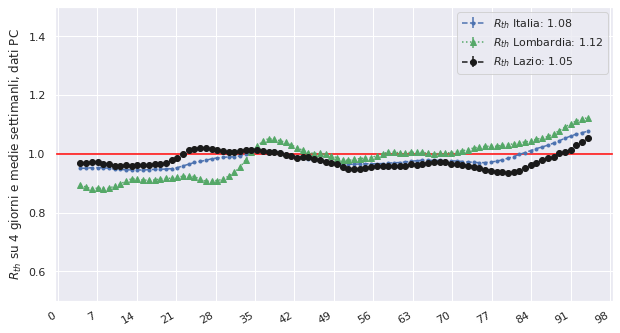

In [26]:
fig, ax = plt.subplots(figsize=(10,6))

what = 'nuovi_positivi'
what = 'ricoverati_con_sintomi' # faq ISS https://www.iss.it/primo-piano/-/asset_publisher/o4oGR9qmvUz9/content/faq-sul-calcolo-del-rt
data = df[what][-100:]
x , y = Rth(data)
ax.errorbar(x , y, yerr=0, fmt='b.--', label='$R_{th}$'+' Italia: {0:.2f}'.format(y[-1]))

data = Lombardia[what][-100:]
x , y = Rth(data)
ax.errorbar(x, y, yerr=0, fmt='g^:', label='$R_{th}$'+' Lombardia: {0:.2f}'.format(y[-1]))

data = Lazio[what][-100:]
x , y = Rth(data)
ax.errorbar(x , y, yerr=0, fmt='ko--', label='$R_{th}$'+' Lazio: {0:.2f}'.format(y[-1]))

ax.axhline(1, color='red')
ax.set_ylabel(r'$R_{th}$ su 4 giorni e medie settimanli, dati PC')
ax.xaxis.set_major_locator(MultipleLocator(7))

ax.set_ylim(0.5,1.5)
fig.autofmt_xdate()
ax.legend()
#ax.grid()
#sns.set_theme()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:109: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in true_divide


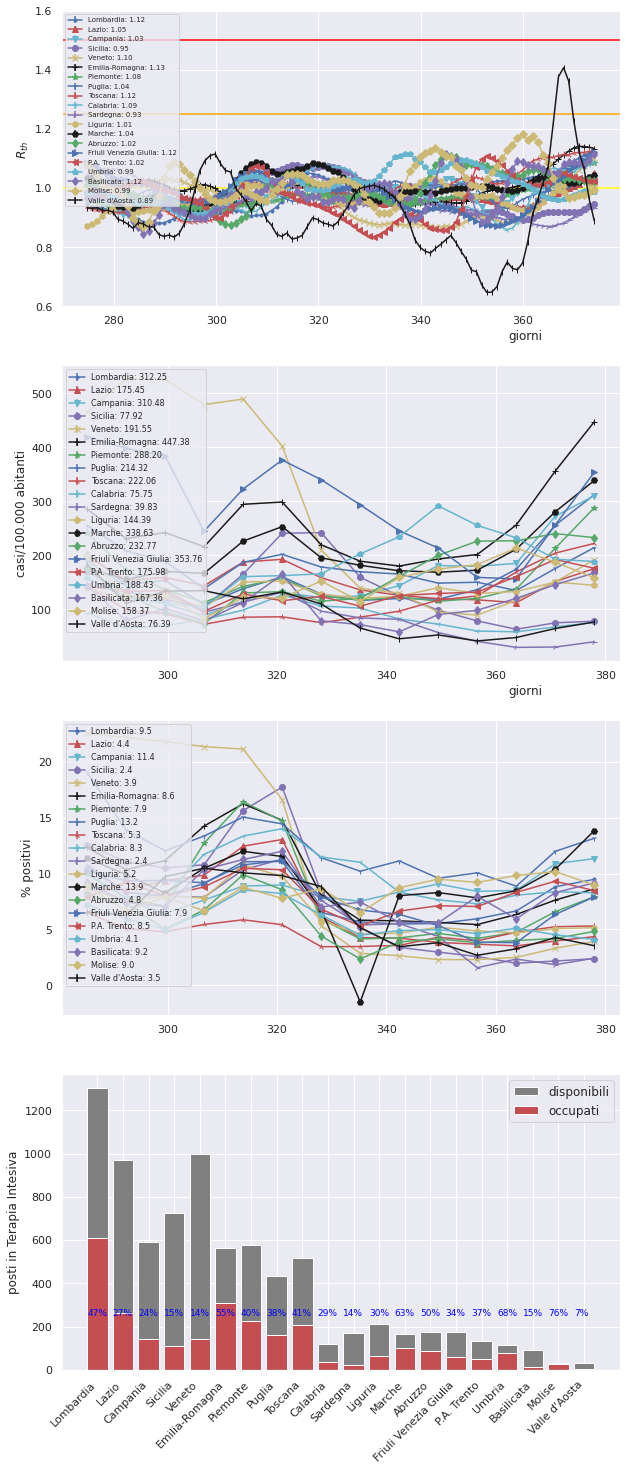

In [27]:
col    = ('b.-', 'r^-', 'cv-', 'mo-', 'yx-', 'k+-', 'g*-', 'b1-', 'r2-', 'c3-', 'm4-', 'yh-', 'kH-', 'gd-', 'b>-', 'r<-', 'cp-', 'md-', 'yD-', 'k|-', 'g,-')
regioni = np.array(dpr['Regione'])
ti = np.array(dpr['terapia_intensiva'])
tie = np.array(dpr['ti_esitenti'])
agenas = np.array(dpr['agenas'])
tir  = []
RthL = []
days = 100
people = np.array(dpr['Popolazione'])/100
fig, ax = plt.subplots((4), figsize=(10,25))
for r in range(0, len(regioni)):
  if regioni[r]=='Trentino Alto Adige':
    
    regioni[r] = 'P.A. Trento'
  drt = dr.loc[(dr['denominazione_regione'] == regioni[r])].sort_values(by="data").copy()
 
  data = np.array(drt['ricoverati_con_sintomi'])
  x , y = Rth(data)
  RthL.append(y[-1])
  average_day=7
  ax[0].errorbar(x[-days:], y[-days:], yerr=0, fmt=col[r], label='{0:s}: {1:.2f}'.format(regioni[r],y[-1]))
  tir.append(np.array(drt['terapia_intensiva'])[-1])
  data2 = np.array(drt['nuovi_positivi'])/people[r]
  x, y, err = ManSdtSubArr(data2, average_day)
  ax[1].errorbar(x[-np.int(days/average_day):], y[-np.int(days/average_day):]*average_day, yerr=0, fmt=col[r], label='{0:s}: {1:.2f}'.format(regioni[r],y[-1]*average_day))
  data3 = np.array(drt['nuovi_positivi'])/np.gradient(drt['tamponi'])
  x, y, err = ManSdtSubArr(data3, average_day)
  ax[2].errorbar(x[-np.int(days/average_day):], y[-np.int(days/average_day):]*100, yerr=0, fmt=col[r], label='{0:s}: {1:.1f}'.format(regioni[r],y[-1]*100))
 
ax[3].bar(regioni, agenas, width=0.8, color='gray', align='center', label='disponibili')
ax[3].bar(regioni, tir, width=0.8, color='r', align='center', label='occupati')
for i in range(regioni.size):
  plt.annotate('{:.0f}%'.format(100*tir[i]/agenas[i]), (i-0.4,250), fontsize=9, color='blue')
 
ax[0].legend(loc=2, prop={'size': 7})
ax[0].set_ylim(bottom=0.6, top=1.6)
ax[0].axhline(1.5, color='red')
ax[0].axhline(1.25, color='orange')
ax[0].axhline(1, color='yellow')
#ax[0].grid()
ax[0].set_xlabel('giorni', horizontalalignment = 'left', x=0.8)
ax[1].set_xlabel('giorni', horizontalalignment = 'left', x=0.8)
ax[0].set_ylabel('$R_{th}$', horizontalalignment = 'left', x=0.8)
ax[1].set_ylabel('casi/100.000 abitanti')
ax[1].legend(loc=2, prop={'size': 8})
#ax[1].grid()
ax[2].set_ylabel('% positivi')
ax[2].legend(loc=2, prop={'size': 8})
#ax[2].grid()
ax[3].set_ylabel('posti in Terapia Intesiva')
ax[3].legend(loc=0, prop={'size': 12})
plt.setp(ax[3].get_xticklabels(), rotation=45, ha='right')
plt.show()

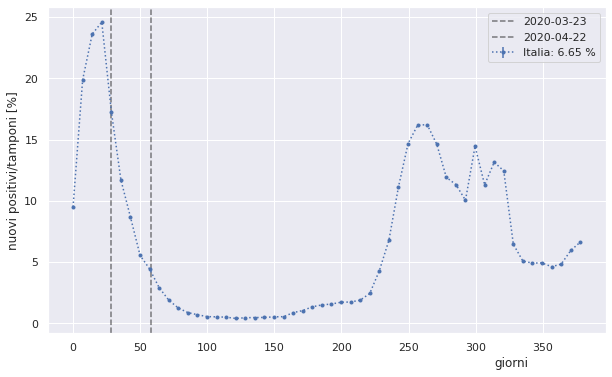

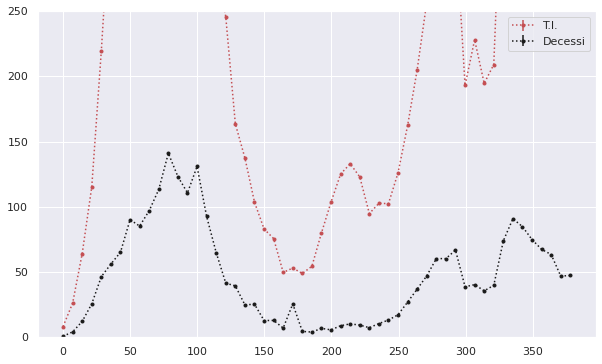

In [28]:
def tamp_perc(average_day=1):
  fig, ax = plt.subplots(figsize=(10,6))
  x = np.linspace(0, len(df['data']), len(df['data']))
  a = df['nuovi_positivi']
  b = np.gradient(df['tamponi'])
  c = a/b
 
  x, y, err = ManSdtSubArr(c, average_day)
 
  ax.errorbar(x,y*100, yerr=err, fmt='b:.', label = "Italia: {0:.2f} %".format(y[-1]*100))
  #GFPlot(y, ax, 4, 'b', label='casi', stat=True)
  ax.set_xlabel('giorni', horizontalalignment = 'left', x=0.8)
  ax.set_ylabel(r'nuovi positivi/tamponi [%]')
  day=28
  ax.axvline(day, color='black', linestyle='--', label='{:s}'.format(df.iloc[day, 0][0:10]), alpha=0.5)
  day=58
  ax.axvline(day, color='black', linestyle='--', label='{:s}'.format(df.iloc[day, 0][0:10]), alpha=0.5)
  #ax.set_ylim(0,1)
  #ax.grid()
  plt.legend()
  plt.show()
  fig, ax = plt.subplots(figsize=(10,6))
  x_, y_, err = ManSdtSubArr(df['terapia_intensiva'], average_day)
  y_ = y_/(y*100)
  ax.errorbar(x_,y_, yerr=0, fmt='r:.', label = "T.I.")
  x_, y_, err = ManSdtSubArr(np.gradient(df['deceduti']), average_day)
  y_ = y_/(y*100)
  ax.errorbar(x_,y_, yerr=0, fmt='k:.', label = "Decessi")
  
  ax.set_ylim(0,250)
  #ax.grid()
  plt.legend()
  plt.show()
tamp_perc(average_day=7)

Tsso POSITIVI [%]
[ 3.43725653  6.3626092   8.15242146  7.4461271   4.99251257  2.92750637
  1.03293313 -0.44229173 -0.88284089 -1.44612711 -1.19241143 -0.87825749
  0.05934602 -0.03815214 -0.9765218  -1.40412135 -1.36358531 -0.81175593
 -0.73806981 -0.09553886  1.58053989  1.48121606]
parametri fit gaussuano:  [1241.51246767   25.40220135   10.09952643]
2 sigma dal picco 55, oggi 154
Tsso OSPEDALIZZATI [%]
[ 3.37190742  6.08713355  7.3961793   6.25957781  4.63352024  2.14640248
  0.50829805 -0.76935179 -1.27458952 -1.41265609 -1.34577648 -0.6772645
 -0.16536263  0.20410854 -0.65503163 -0.85318967 -0.78437665 -0.5537907
 -0.75887704 -0.01386765  1.11476308  2.08173668]
Tsso TERAPIA INTENSIVA [%]
[ 3.29103886  7.61589404  6.87958986  6.43921382  4.7237892   2.78115964
  0.72582177 -0.72922191 -1.25418743 -1.64793337 -1.580967   -0.64744618
  0.17562444  0.2056936  -0.75372629 -0.66476733 -1.15440572 -0.29449167
 -0.52527458  0.6383855   1.39584136  2.30006097]
Tsso DECEDUTI [%]
[ 0.0016

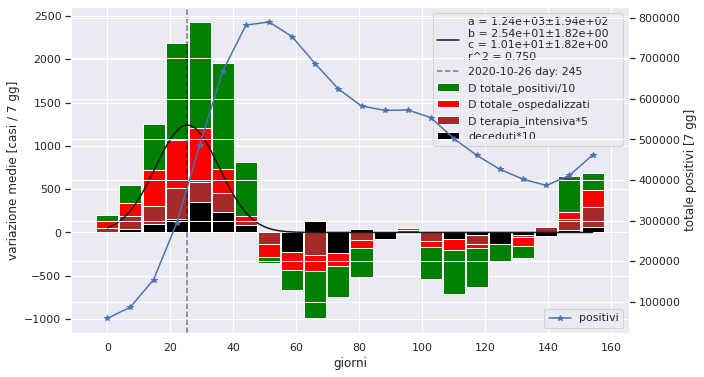

In [29]:
def do_av_plot(df=df, average_day = 7, day_start = 90, x_fit=30):
  fig, ax = plt.subplots(figsize=(10,6))
  df_org = df.copy()
  d0 = day_start
  df = df.tail(day_start)
  day_start = day_start/average_day

  x, y, err = ManSdtSubArr(np.gradient(df['totale_positivi']), average_day)
  xt, yt, errt = ManSdtSubArr(df['totale_positivi'], average_day)

  ax.bar(x,y/10,color='green', width=average_day, label='D totale_positivi/10')
  print ("Tsso POSITIVI [%]")
  print (100*y/yt)

  x, y, err = ManSdtSubArr(np.gradient(df['totale_ospedalizzati']), average_day)
  xt, yt, errt = ManSdtSubArr(df['totale_ospedalizzati'], average_day)

  ax.bar(x,y,color='red', width=average_day, label='D totale_ospedalizzati')
  try:
    sx = x[0:2*x_fit].std()
    ax, par = fittalo(Gauss3,x,y, ax, [y.max(),x_fit, sx], fmt='k')
    print ("parametri fit gaussuano: ", par)
    print ("2 sigma dal picco {:d}, oggi {:d}".format(int(par[1]+3*par[2]), int(x[-1])))
    print ("Tsso OSPEDALIZZATI [%]")
    print (100*y/yt)
    day=int(len(df_org)-d0+par[1])

    ax.axvline(par[1], color='black', linestyle='--', label='{:s} day: {:d}'.format(df_org.iloc[day, 0][0:10], day), alpha=0.5)
  except:
    print ("fit error...")
  x, y, err = ManSdtSubArr(np.gradient(df['terapia_intensiva']), average_day)
  xt, yt, errt = ManSdtSubArr(df['terapia_intensiva'], average_day)
  ax.bar(x,y*5,color='brown', width=average_day, label='D terapia_intensiva*5')
  print ("Tsso TERAPIA INTENSIVA [%]")
  print (100*y/yt)

  x, y, err = ManSdtSubArr(np.gradient(np.gradient(df['deceduti'])), average_day)
  xt, yt, errt = ManSdtSubArr(df['deceduti'], average_day)
  ax.bar(x,y*10,color='black', width=average_day, label='deceduti*10')
  print ("Tsso DECEDUTI [%]")
  print (100*y/yt)

  ax.set_xlabel('giorni')
  ax.set_ylabel('variazione medie [casi / {:d} gg]'.format(average_day))
  ax.legend()
  ax = ax.twinx()
  x = np.linspace(0, len(df['data']), len(df['data']))
  x, y, err = ManSdtSubArr(df['totale_positivi'], average_day)
  ax.plot(x,y, 'b*-', label='positivi')
  ax.legend(loc=4)
  ax.set_ylabel('totale positivi [{:d} gg]'.format(average_day))
  plt.show()
do_av_plot(df=df, average_day = 7, day_start = 160)

Tsso POSITIVI [%]
[27.59687638 18.69766746 14.16836151  9.67185302  4.82925375  2.52702657
  1.45396745  0.37944714 -0.37269401 -1.40605338 -2.51833094 -3.20221567
 -2.95509119 -4.09962361]
parametri fit gaussuano:  [1579.09015268   19.65155296    8.74305019]
2 sigma dal picco 45, oggi 98
Tsso OSPEDALIZZATI [%]
[ 2.89811772e+01  2.01787752e+01  1.29646237e+01  6.96311192e+00
  3.02053747e+00  7.63678574e-03 -6.26141935e-01 -2.29685714e+00
 -3.06435046e+00 -2.91544753e+00 -3.69059939e+00 -3.63174423e+00
 -3.31634995e+00 -4.18367347e+00]
Tsso TERAPIA INTENSIVA [%]
[28.02547771 18.13160423 11.36663525  6.46005232  2.20497011 -1.02994572
 -2.54537868 -3.66443162 -4.05652704 -4.07699991 -5.84739264 -4.07520691
 -4.46559297 -3.54676711]
Tsso DECEDUTI [%]
[ 1.19505495e+01  7.29541367e+00  2.20735027e+00  7.80204088e-01
  1.00541488e-01 -1.76511955e-01 -2.76353024e-03 -6.33442041e-02
 -7.59647111e-02 -8.13016265e-03 -4.98945624e-02 -2.07271629e-02
 -2.81925309e-02 -1.79028572e-02]


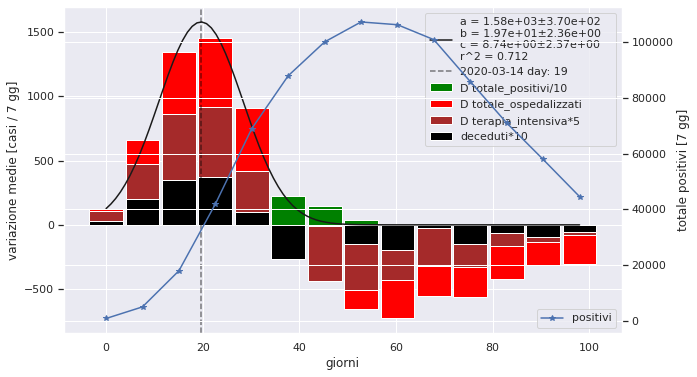

In [30]:
# prima ondata
do_av_plot(df=df.head(100), average_day = 7, day_start = 100)

Tsso POSITIVI [%]
[ 6.7796948   5.80849115  4.61222796  3.48735236  2.47272525  0.84263927
  0.38121355 -1.81095213 -1.27443973 -0.23579662  0.55488658  0.15840399
 -0.77434548 -1.77172735 -1.18420191 -3.76128898 -3.15697595 -0.81587142
  0.35784624  1.19782962]
parametri fit gaussuano:  [96.11991215  9.30437746 11.61286872]
2 sigma dal picco 44, oggi 140
Tsso OSPEDALIZZATI [%]
[ 4.49927431  4.35545952  3.24541053  1.15993273  1.31167895 -0.34274271
 -0.69376826 -1.00205991 -0.87326156  0.54223344  0.12816405  0.17091711
 -0.70164175 -1.17844288 -0.96235195 -0.66180595 -1.24880211 -1.56072834
 -0.03855591  1.75328947]
Tsso TERAPIA INTENSIVA [%]
[ 3.77733598  3.25914149  2.98598416  2.98898794  1.45299145  0.16200891
 -0.38870704 -1.20456467 -1.12306972  0.72150072  0.13882462  0.56689342
 -1.09056425 -0.67635271  0.0499002  -1.05374078 -1.00278552 -1.10701107
  0.22595223  1.94541231]
Tsso DECEDUTI [%]
[ 0.02287582  0.14129283  0.09509612  0.26255406 -0.06035113 -0.08550995
 -0.0344068

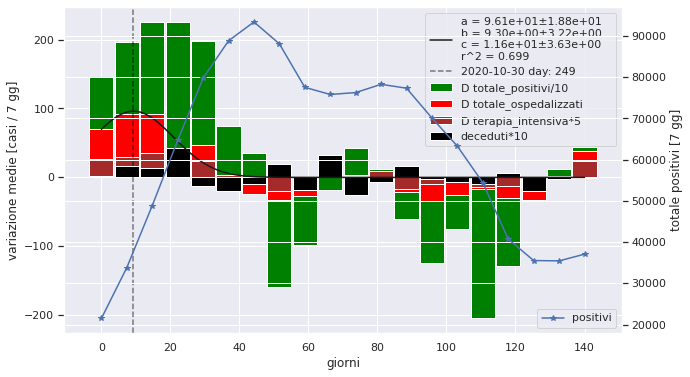

In [31]:
# Lazio
do_av_plot(df=Lazio, average_day = 7, day_start = 140)

Max 38 3940
Max 288 3501


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in multiply


Max 37 743
Max 288 682


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in multiply


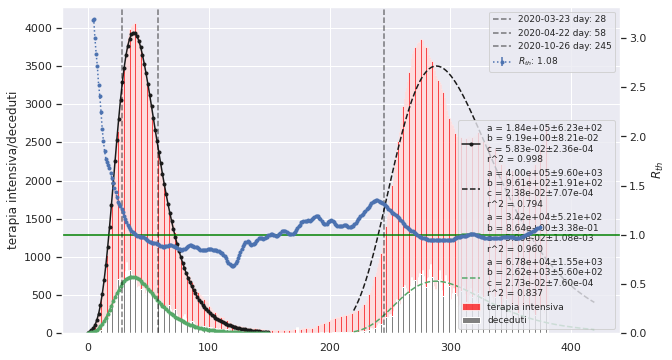

In [32]:
def predicGem(df=df, P_start=220, P_max = 285, slope=1):
  fig, ax = plt.subplots(figsize=(10,6))
  x = np.linspace(0, len(df['data']), len(df['data']))
  
  y = np.array(df['terapia_intensiva'])
  ax.bar(x,y, color='red', alpha=0.7, label='terapia intensiva', width=1)
  ax, par = fittalo(dGompertz, x[x<150], y[x<150], ax, [1e5,9., 0.1], 'k.-')
  print ("Max {0:.0f} {1:.0f}".format(np.log(par[1])/par[2], par[0]*par[2]/np.exp(1)))
  
  # Gompertz
  # a is the asymptote limit of grow
  # b sets the displacement along the x-axis 
  # c sets the growth rate (y scaling)
  c = par[2]*slope
  a = par[0]
  b = np.exp(P_max*c)

  xp = np.linspace(P_start, P_start+199, 200)

  yp = dGompertz(xp,*[a,b,c])

  for i in range(P_start, len(x)):
    yp[i-P_start]=y[i]

  
  ax, par = fittalo(dGompertz, xp, yp, ax, [a,b,c], 'k--')
  print ("Max {0:.0f} {1:.0f}".format(np.log(par[1])/par[2], par[0]*par[2]/np.exp(1)))

  
  y = np.gradient(df['deceduti'])

  ax.bar(x,y, color='gray', alpha=1, label='deceduti', width=1)
  ax, par = fittalo(dGompertz, x[x<150], y[x<150], ax, [3e4,8., 0.1], 'g.-')
  print ("Max {0:.0f} {1:.0f}".format(np.log(par[1])/par[2], par[0]*par[2]/np.exp(1)))
  
  c = par[2]*slope
  a = par[0]
  b = np.exp(P_max*c)

  xp = np.linspace(P_start, P_start+199, 200)

  yp = dGompertz(xp,*[a,b,c])
  for i in range(P_start, len(x)):

    yp[i-P_start]=y[i]

  
  ax, par = fittalo(dGompertz, xp, yp, ax, [a,b,c], 'g--')
  print ("Max {0:.0f} {1:.0f}".format(np.log(par[1])/par[2], par[0]*par[2]/np.exp(1)))
  
  
  ax.set_ylabel(r'terapia intensiva/deceduti')
  ax.set_ylim(bottom=0)
  ax.legend(loc=4, prop={'size': 9})
  ax = ax.twinx()
  
  # ricoverati_con_sintomi
  # nuovi_positivi
  data = df['ricoverati_con_sintomi']
  x_ , y_ = Rth(data)
  
  ax.errorbar(x_, y_, yerr=0, fmt='b.:', label='$R_{th}$'+': {0:.2f}'.format(y_[-1]))
  ax.axhline(1, color='green')
  ax.set_xlabel('giorni', horizontalalignment = 'left', x=0.8)
  ax.set_ylabel(r'$R_{th}$')
  day=28
  ax.axvline(day, color='black', linestyle='--', label='{:s} day: {:d}'.format(df.iloc[day, 0][0:10], day), alpha=0.5)
  day=58
  ax.axvline(day, color='black', linestyle='--', label='{:s} day: {:d}'.format(df.iloc[day, 0][0:10], day), alpha=0.5)
  day=245
  ax.axvline(day, color='black', linestyle='--', label='{:s} day: {:d}'.format(df.iloc[day, 0][0:10], day), alpha=0.5)
  
  ax.legend(loc=1, prop={'size': 9})
  ax.set_ylim(bottom=0)
  ax.grid()
  plt.show()
predicGem(df=Italia, P_start=220, P_max = 275, slope=2.2)

Max 37 1342
Max 284 795


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in multiply


Max 33 393
Max 275 157


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in exp


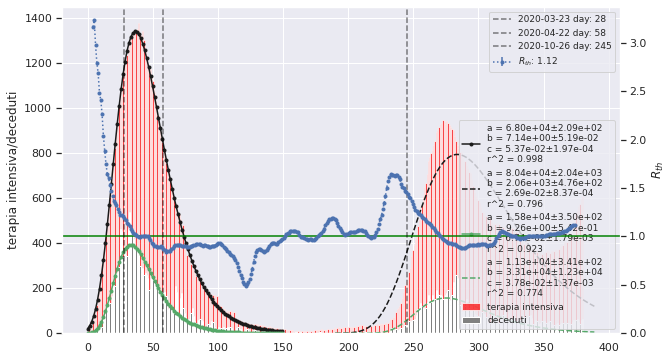

In [33]:
predicGem(df=Lombardia, P_start=190, P_max = 285, slope=0.7)

Max 48 196
Max 295 353


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in multiply


Max 53 11
Max 295 49


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in multiply


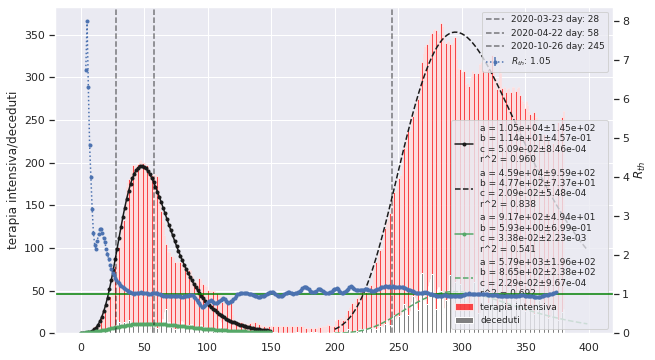

In [34]:
predicGem(df=Lazio, P_start=200, P_max = 300, slope=2.3)

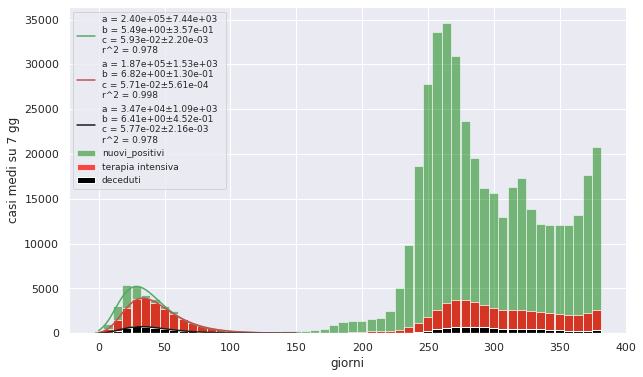

In [35]:
fig, ax = plt.subplots(figsize=(10,6))
average_day = 7
# y = df['totale_positivi']
# x, y, err = ManSdtSubArr(y, average_day)
# ax.plot(x,y, 'b.', alpha=0.5, label='totale_positivi') 

y = df['nuovi_positivi']
x, y, err = ManSdtSubArr(y, average_day)
ax.bar(x,y, color='green', alpha=0.5, label='nuovi_positivi', width=average_day) 
fittalo(dGompertz, x[x<150], y[x<150], ax, [4e6,7., 0.1], 'g')
y = df['terapia_intensiva']
x, y, err =  ManSdtSubArr(y, average_day)
ax.bar(x,y, color='red', alpha=0.7, label='terapia intensiva', width=average_day)
fittalo(dGompertz, x[x<150], y[x<150], ax, [1e5,9., 0.1], 'r')

y = np.gradient(df['deceduti'])
x, y, err =  ManSdtSubArr(y, average_day)
ax.bar(x,y, color='black', alpha=1, label='deceduti', width=average_day)
fittalo(dGompertz, x[x<150], y[x<150], ax, [3e4,8., 0.1], 'k')
ax.set_xlabel('giorni')
ax.set_ylabel('casi medi su 7 gg')
ax.legend(loc=2, prop={'size': 9})
#ax.grid()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in exp


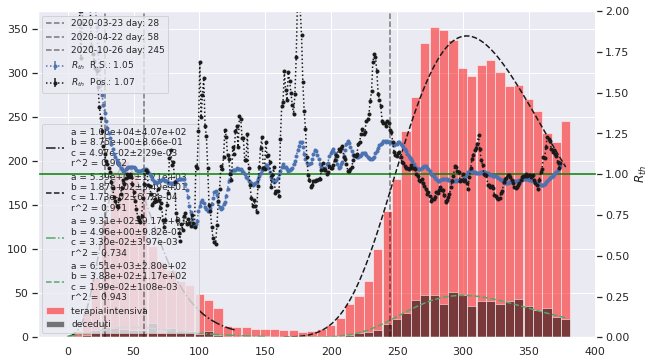

In [36]:
def do_av_fit(df=df, average_day = 7, P_start = 180, exp_peak = 275, RthN = 7, RthD = 4):
  fig, ax = plt.subplots(figsize=(10,6))


  y = np.array(df['terapia_intensiva'])
  x, y, err =  ManSdtSubArr(y, average_day)
  ax.bar(x,y, color='red', alpha=0.5, label='terapia intensiva', width=average_day)
  ax, par = fittalo(dGompertz, x[x<130], y[x<130], ax, [1e5,9., 0.1], 'k-.')

  # Gompertz
  # a is the asymptote limit of grow
  # b sets the displacement along the x-axis 
  # c sets the growth rate (y scaling)
  c = par[2]
  a = par[0]
  b = np.exp(exp_peak*c)
  try:
    ax, par = fittalo(dGompertz, x[x>P_start], y[x>P_start], ax, [a,b,c], 'k--')
  except:
    print ("unfittable")

  y = np.gradient(df['deceduti'])
  x, y, err =  ManSdtSubArr(y, average_day)
  ax.bar(x,y, color='black', alpha=0.5, label='deceduti', width=average_day)
  ax, par = fittalo(dGompertz, x[x<150], y[x<150], ax, [3e4,8., 0.1], 'g-.')

  # Gompertz
  # a is the asymptote limit of grow
  # b sets the displacement along the x-axis 
  # c sets the growth rate (y scaling)
  c = par[2]
  a = par[0]
  b = np.exp(exp_peak*c)
  try:
    ax, par = fittalo(dGompertz, x[x>P_start], y[x>P_start], ax, [a,b,c], 'g--')
  except:
    print ("unfittable")
  ax.legend(loc=3, prop={'size': 9})
  ax = ax.twinx()
  
  data = df['ricoverati_con_sintomi']
  x_ , y_ = Rth(data, RthN, RthD )
  
  # ax.errorbar(x, y, yerr=0, fmt='k.:', label='running avarege')
  ax.errorbar(x_, y_, yerr=0, fmt='b.:', label='$R_{th}$'+'  R.S.: {0:.2f}'.format(y_[-1]))
  data = df['nuovi_positivi']
  x_ , y_ = Rth(data, RthN, RthD )
  ax.errorbar(x_, y_, yerr=0, fmt='k.:', label='$R_{th}$'+'  Pos.: {0:.2f}'.format(y_[-1]))
  ax.axhline(1, color='green')
  ax.set_xlabel('giorni', horizontalalignment = 'left', x=0.8)
  ax.set_ylabel(r'$R_{th}$')
  day=28
  ax.axvline(day, color='black', linestyle='--', label='{:s} day: {:d}'.format(df.iloc[day, 0][0:10], day), alpha=0.5)
  day=58
  ax.axvline(day, color='black', linestyle='--', label='{:s} day: {:d}'.format(df.iloc[day, 0][0:10], day), alpha=0.5)
  day=245
  ax.axvline(day, color='black', linestyle='--', label='{:s} day: {:d}'.format(df.iloc[day, 0][0:10], day), alpha=0.5)
  
  ax.legend(loc=2, prop={'size': 9})
  ax.set_ylim(bottom=0, top=2)
  ax.grid()
  plt.show()
do_av_fit(df=Lazio, average_day = 7, P_start=160, exp_peak=290, RthN = 7, RthD = 4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in exp


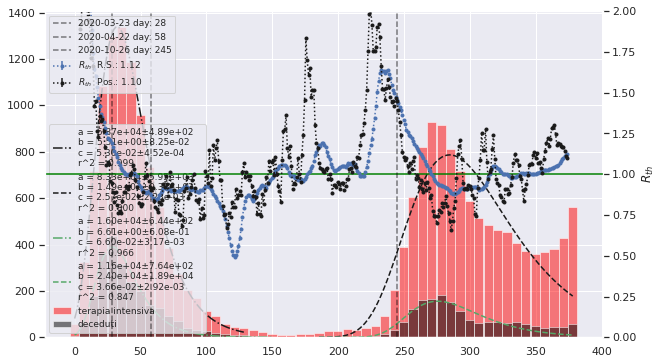

In [37]:
do_av_fit(df=Lombardia, average_day = 7, P_start=180, exp_peak=275, RthN = 7, RthD = 4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in exp


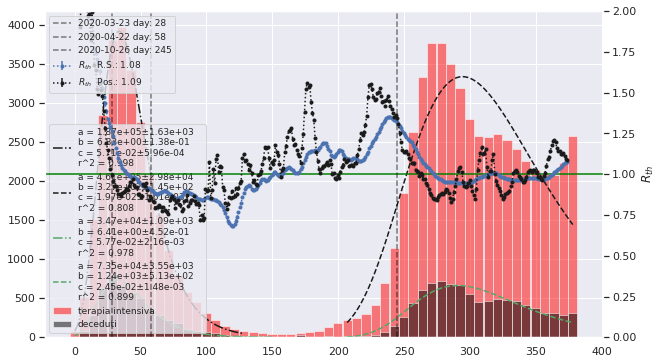

In [38]:
do_av_fit(df=Italia, average_day = 7, P_start=200, exp_peak=300, RthN = 7, RthD = 4)

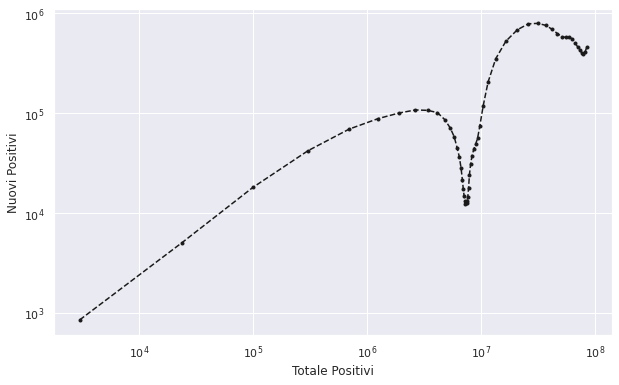

In [39]:
from scipy import integrate
fig, ax = plt.subplots(figsize=(10,6))
xi, yi, eri = ManSdtSubArr(integrate.cumtrapz(df['totale_positivi']),7)
xp, yp, eri = ManSdtSubArr(df['totale_positivi'],7)
ax.plot(yi,yp,'k.--')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Totale Positivi')
ax.set_ylabel('Nuovi Positivi')
plt.show()

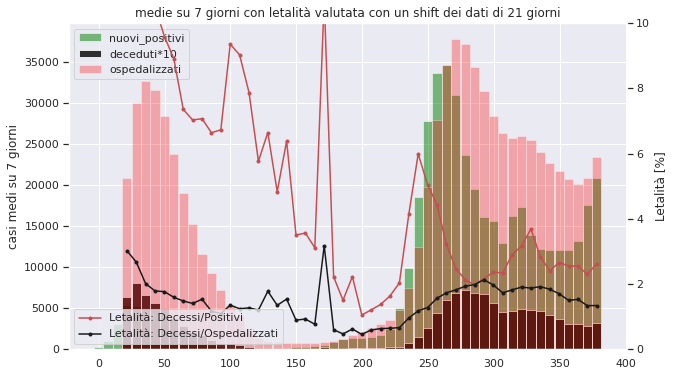

In [40]:
def letalita(df=df, average_day = 7, day_shift=14, day_start = 90):
  fig, ax = plt.subplots(figsize=(10,6))
  df_org = df.copy()
  d0 = day_start
  df = df.tail(day_start)
  day_start = day_start/average_day



  x, y, err    = ManSdtSubArr(df['nuovi_positivi'], average_day)
  xt, yt, errt = ManSdtSubArr(np.gradient(df['deceduti']), average_day)
  xo, yo, erro = ManSdtSubArr(df['totale_ospedalizzati'], average_day)

  ax.bar(x,y, color='green', alpha=0.5, label='nuovi_positivi', width=average_day) 
  week_shift = int(day_shift/average_day)
  if week_shift !=0:
    x=x[week_shift:]
    y=y[:-week_shift]
    xt=xt[:-week_shift]
    yt=yt[week_shift:]
    yo=yo[week_shift:]
  ax.bar(x,yt*10, color='black', alpha=0.8, label='deceduti*10', width=average_day)
  ax.bar(x,yo, color='red', alpha=0.3, label='ospedalizzati', width=average_day) 
  ax.set_ylabel('casi medi su {:d} giorni'.format(average_day))
  ax.legend(loc=2)
  ax = ax.twinx()
  ax.plot(x,(yt/y)*100,'r.-', label='Letalità: Decessi/Positivi')
  ax.plot(x,(yt/yo)*100,'k.-', label='Letalità: Decessi/Ospedalizzati')

  ax.legend(loc=3)
  ax.set_ylim(0,10)
  ax.set_ylabel('Letalità [%]')
  ax.grid()
  plt.title('medie su {:d} giorni con letalità valutata con un shift dei dati di {:d} giorni'.format(average_day, day_shift))
  plt.show()
letalita(df=df, average_day = 7, day_shift=21, day_start = len(df))

Olbia-Tempio >>> non esiste
Carbonia-Iglesias >>> non esiste
Medio Campidano >>> non esiste
Ogliastra >>> non esiste


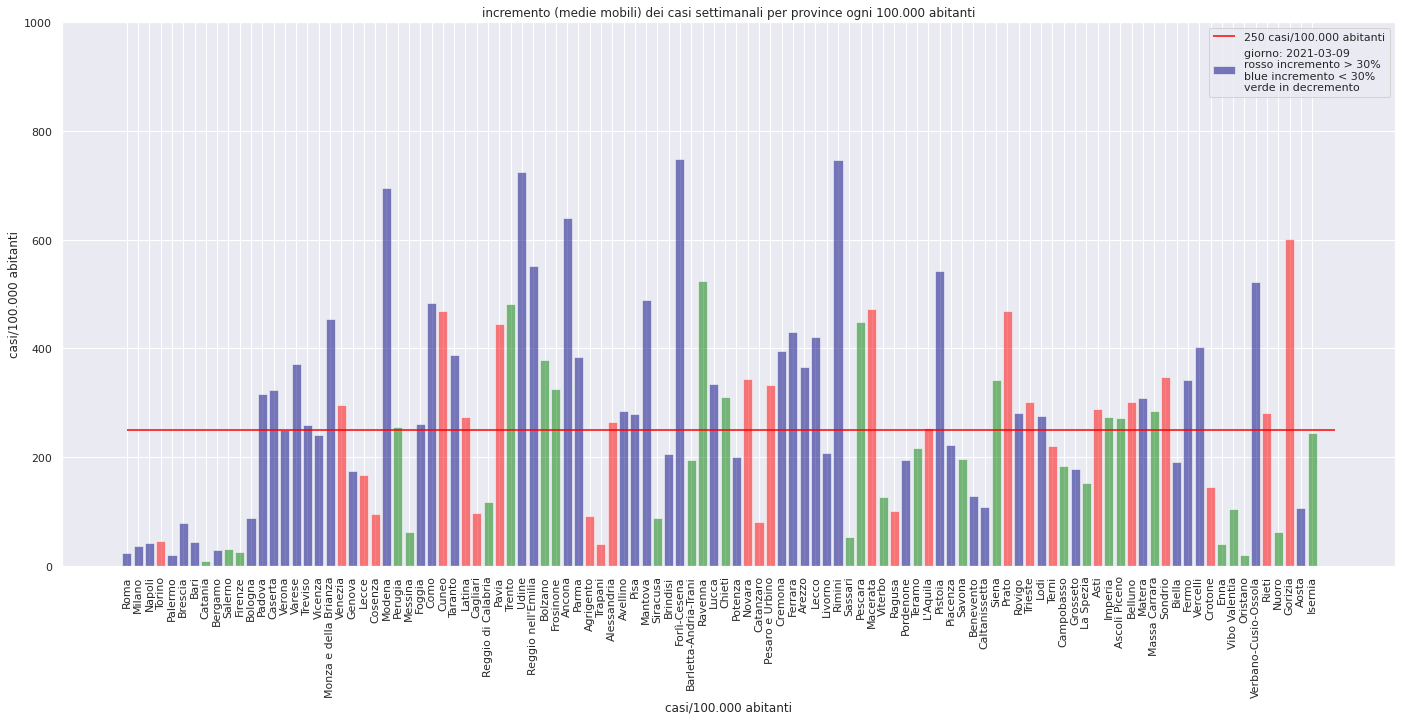

In [41]:
def casi_provincia(dp, provincia):
  try:
    dfc = dp.loc[(dp['denominazione_provincia'] == provincia)].sort_values(by="data").copy()
    x, y, err = ManSdtSubArr(np.gradient(dfc['totale_casi'])/(pr[pr.Provincia==provincia].Popolazione.values/100000), average_day)
  except:
    print(provincia+" >>> non esiste")
    x = y = err = []
  return x, y, err
def plot_p(p,c, date, h=True, save=True):
  if h:
    fig, ax = plt.subplots(figsize=(23.9, 10))
  else:
    fig, ax = plt.subplots(figsize=(10.80,19.20))
  clrs = ['red' if (x[0] > 1.3*x[1]) else 'green' if (x[0] < x[1]) else 'navy' for x in c ]
  c = np.array(c)
  if h:
    ax.bar(p, c[:,0], align='center', color=clrs, alpha=0.5, 
            label='giorno: {:s}\nrosso incremento > 30%\nblue incremento < 30%\nverde in decremento'.format(str(date)[0:10]))
    ax.hlines(250, 0, 107, color='red', label='250 casi/100.000 abitanti')
    ax.set_ylabel('casi/100.000 abitanti')
    ax.set_xlabel('province')
    plt.setp(ax.get_xticklabels(), rotation=90, ha='center')
  else: 
    ax.barh(p, c[:,0], align='center', color=clrs, alpha=0.5, 
          label='giorno: {:s}\nrosso incremento > 30%\nblue incremento < 30%\nverde in decremento'.format(str(date)[0:10]))
    ax.vlines(250, 0, 107, color='red', label='250 casi/100.000 abitanti')
    ax.set_xlabel('casi/100.000 abitanti')
    ax.set_ylabel('province')
  ax.set_title('incremento (medie mobili) dei casi settimanali per province ogni 100.000 abitanti')
  ax.set_xlabel('casi/100.000 abitanti')
  ax.set_ylim(0,1000)
  plt.legend()
  if save:
    png_dir = './drive/MyDrive/tmp/'
    png_image = png_dir+'img{:d}.png'.format(j)
    fig.savefig(png_image, bbox_inches='tight')
  else:
    plt.show()
#
# crea film jpg
##############
#
# import datetime as dt
# date = dt.datetime(2021, 2, 1)
# from google.colab import drive
# drive.mount('/content/drive')

# average_day = 7
# dfc = dp.loc[(dp['denominazione_provincia'] == 'Roma')].sort_values(by="data").copy()

# for j in range(len(dfc[(dfc.data>str(date))])):
#   date += dt.timedelta(days=1)
#   p = []
#   c = []
#   for i, provincia in enumerate(pr.Provincia):
#     x, y , err = casi_provincia(dp[dp.data<str(date)], provincia)
#     if len(y):
#       p.append(provincia)
#       c.append([y[-1], y[-2]])
#   plot_p(p,c, date, h=True)
################
p = []
c = []
for i, provincia in enumerate(pr.Provincia):
  x, y , err = casi_provincia(dp, provincia)
  if len(y):
    p.append(provincia)
    c.append([y[-1], y[-2]])
date = dp.data.values[-1]
plot_p(p,c, date, h=True, save=False)

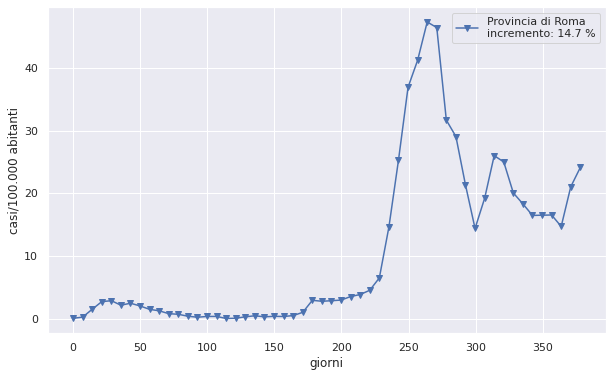

In [58]:
provincia='Roma'
x,y, err = casi_provincia(dp, provincia)
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(x, y, 'bv-', label='Provincia di '+provincia+'\nincremento: {:.1f} %'.format(100*(y[-1]-y[-2])/y[-2]))
ax.set_xlabel('giorni')
ax.set_ylabel('casi/100.000 abitanti')
plt.legend()
plt.show()
